In [19]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [20]:
dataset = 'point_history.csv'
model_save_path = 'point_history_classifier.hdf5'

# Classification number setting

In [21]:
NUM_CLASSES = 4

# Input time duration length

In [22]:
TIME_STEPS = 16
DIMENSION = 2

# Read training data

In [23]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [24]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [26]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [27]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                792       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                250       
                                                                 
 dense_5 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,086
Trainable params: 1,086
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early censoring
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [29]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training


In [30]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/32 [..............................] - ETA: 13s - loss: 1.3919 - accuracy: 0.1953
Epoch 1: saving model to point_history_classifier.hdf5
32/32 [==============================] - 1s 6ms/step - loss: 1.3708 - accuracy: 0.3575 - val_loss: 1.3613 - val_accuracy: 0.5680
Epoch 2/1000
 1/32 [..............................] - ETA: 0s - loss: 1.3620 - accuracy: 0.5312
Epoch 2: saving model to point_history_classifier.hdf5
32/32 [==============================] - 0s 3ms/step - loss: 1.3439 - accuracy: 0.4975 - val_loss: 1.3307 - val_accuracy: 0.5793
Epoch 3/1000
 1/32 [..............................] - ETA: 0s - loss: 1.3377 - accuracy: 0.4609
Epoch 3: saving model to point_history_classifier.hdf5
32/32 [==============================] - 0s 3ms/step - loss: 1.3161 - accuracy: 0.5118 - val_loss: 1.2963 - val_accuracy: 0.5665
Epoch 4/1000
 1/32 [..............................] - ETA: 0s - loss: 1.3251 - accuracy: 0.4922
Epoch 4: saving model to point_history_classifier.hdf5
32/32 [=

In [31]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [32]:
# Inference test

predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 47ms/step
[0.9432848  0.01199116 0.02878425 0.01593979]
0


# Confusion matrix

42/42 [==============================] - 0s 849us/step


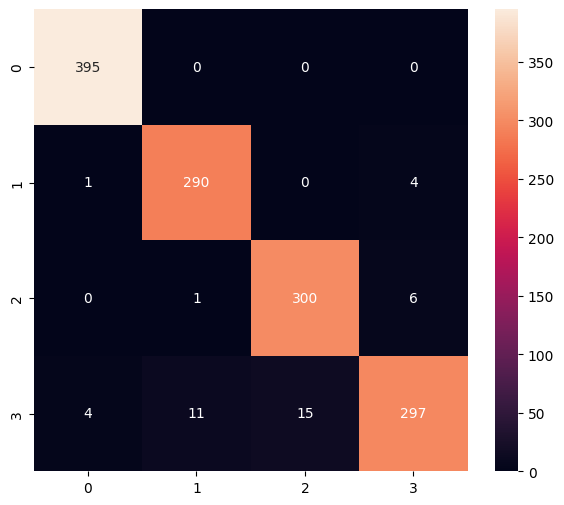

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.96      0.98      0.97       295
           2       0.95      0.98      0.96       307
           3       0.97      0.91      0.94       327

    accuracy                           0.97      1324
   macro avg       0.97      0.97      0.97      1324
weighted avg       0.97      0.97      0.97      1324



In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [34]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [37]:
tflite_save_path = 'point_history_classifier.tflite'

In [38]:
# Transform (quantize) model
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp9fiuoymy/assets


INFO:tensorflow:Assets written to: /tmp/tmp9fiuoymy/assets
2023-01-08 05:57:36.892856: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-08 05:57:36.892910: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-08 05:57:36.893097: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9fiuoymy
2023-01-08 05:57:36.894284: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-01-08 05:57:36.894313: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9fiuoymy
2023-01-08 05:57:36.897813: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-01-08 05:57:36.912862: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9fiuoymy
2023-01-08 05:57:36.918773: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

6460

# Inference test

In [39]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [40]:
# Get I / O tensor

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [41]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [42]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 459 µs, sys: 58 µs, total: 517 µs
Wall time: 530 µs


In [43]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.9432848  0.01199116 0.02878425 0.01593979]
0
